In [1]:
#importuje wszytskie potrzebne biblioteki w tym biblioteke kwant
import kwant
import numpy as np
import types
import matplotlib.pyplot as plt
      
    
#Obliczenia prowadze sa w jednostkach atomowych e=h=me=1. Tutaj definiuje wspolczynniki konwersji.
def eV2au(energy): #eV -> j.a
    return energy*0.03674932587122423
def nm2au(length): #nm -> j.a
    return length*18.89726133921252
def T2au(length):  #nm -> j.a
    return length*4.254382E-6


# Zdefiniowanie układu

In [2]:
############################################################################################
## W ramach zdefiniowania ukladu musimy zdefiniowac funkcje okreslajace energie potrzebne ##
## do przeskoku do tego samego wezla oraz wezlow sasiadujacych. Robimy to w funkcjach     ##
## onsite() oraz hopping_x() i hopping_y().
############################################################################################

#definicja ukladu do symulacji
def make_system(nw, Bz):
    m=nw.m
    dx=nw.dx
    L=nm2au(nw.L)
    W=nm2au(nw.W)
    V0=nw.V0
    sigma = nw.sigma
    x0 = nm2au(L/2)
    y0 = nm2au(W)
    Bz = T2au(Bz)
    Rmin = nm2au(600)
    Rmax = nm2au(630)
    
    def shape(pos):
        x,y = pos
        if (-Rmax < x < Rmax):
            return ((Rmin)**2 < (x**2 + y**2) < (Rmax)**2)
        elif (-L/2 < x < L/2):
            return (-W < y < W)
            

    def magnetic(x0, y0, x1, y1):
        return np.exp(-0.5j*Bz*(x1 - x0)*(y0+y1))
        
    
    def potential_v0(x, y):
        return V0*np.exp((-(x-x0)**2 - (y-y0)**2)/(sigma)**2)
    
    
    def potential_B(x1, y1, x2, y2):
        
        
        return np.exp(1j * line_integral(x1, y1, x2, y2) )
    
    def onsite(site):
        (x, y) = site.pos
        t=1.0/(2.0*m*dx*dx)
        return 4*t + potential_v0(x,y)

    def hopping_x(sitei, sitej):
        (xi, yi) = sitei.pos
        (xj, yj) = sitej.pos
        t=1.0/(2.0*m*dx*dx)        
        return -t*magnetic(xi, yi, xj, yj)
    
    def hopping_y(sitei, sitej):
        (xi, yi) = sitei.pos
        (xj, yj) = sitej.pos
        t=1.0/(2.0*m*dx*dx)
        return -t*magnetic(xi, yi, xj, yj)

    
    def shape_lead(pos):
        x,y = pos
        return (-W < y < W)


    
    # W ramach definicji ukladu kolejno:
    # 1. Definujemy uklad - funkcja kwant.Builder()  
    # 2. Okreslamy geometrie siatki - kwant.lattice.square(dx, norbs=1)
    # 3. Uzupelniamy macierz
    sys = kwant.Builder()  
    lat = kwant.lattice.square(dx, norbs=1)
#     sys[(lat(i,j) for i in range(L) for j in range(-W,W))]=onsite
    sys[lat.shape(shape,(0,Rmin+nm2au(5)))] = onsite
    sys[(kwant.builder.HoppingKind((-1,0), lat, lat))] = hopping_x
    sys[(kwant.builder.HoppingKind((0,-1), lat, lat))] = hopping_y
    
    
    #dolaczam lewy kontakt do naszego ukladu
    lead_left = kwant.Builder(kwant.TranslationalSymmetry((-dx, 0)))    
    lead_left[lat.shape(shape_lead, (0,0))] = onsite
    lead_left[(kwant.builder.HoppingKind((-1,0), lat, lat))] = hopping_x
    lead_left[(kwant.builder.HoppingKind((0,-1), lat, lat))] = hopping_y
    sys.attach_lead(lead_left)
    
    
    #dolaczam prawy kontakt do naszego ukladu
    lead_right = kwant.Builder(kwant.TranslationalSymmetry((dx, 0)))    
    lead_right[lat.shape(shape_lead, (0,0))] = onsite
    lead_right[(kwant.builder.HoppingKind((-1,0), lat, lat))] = hopping_x
    lead_right[(kwant.builder.HoppingKind((0,-1), lat, lat))] = hopping_y
    sys.attach_lead(lead_right)
    
    #finalizujemy uklad
    sys = sys.finalized()
    return sys

# Zdefiniowanie funkcji do liczenia transportu

In [3]:
############################################################################################
##       Definiujemy rozne funkcje liczace podstawowe wlasnosci fizyczne                  ##
############################################################################################

#funkcja wyliczajaca relacje dyspersji w kontakcie nr_lead w granicach [-k_max,k_max] z nk punktami
def disperssion(nw, nr_lead, k_max, nk):
    dx=nw.dx
    sys=make_system(nw)
    momenta = np.linspace(-k_max*dx,k_max*dx,nk)
    bands=kwant.physics.Bands(sys.leads[nr_lead])
    energies=[bands(k) for k in momenta]
    return (momenta/dx)*nm2au(1.0), energies

#funkcja liczaca wspolczynnik odbicia oraz wspolczynnik transmisji
def transmission_reflection(nw, E):
    E=eV2au(E)
    sys=make_system(nw)
    smatrix=kwant.smatrix(sys,E) #Zwraca macierz rozpraszania, kanały mody itp
    r=smatrix.transmission(0,0)
    t=smatrix.transmission(1,0)
    return r, t

#funkcja liczaca wspolczynnik transmisji
def transmission(nw, E, B):
    E=eV2au(E)
    sys=make_system(nw, B)
    smatrix=kwant.smatrix(sys,E)
    t=smatrix.transmission(1,0)
    print(B)
    return t

#funkcja liczaca konduktacje - uzyto formuly Landauera
def conductance(nw, Bmax, ne):
    magnetic=np.linspace(0,Bmax,ne)
    cond=[transmission(nw, 0.05, B) for B in magnetic]
    return magnetic, cond

#funkcja rysujaca funkcje falowa elektronu o energii E wchodzacego do kontaku nr_lead
def wave_function(nw, E, nr_lead, B):
    E=eV2au(E)
    sys=make_system(nw, B)
    wave=kwant.wave_function(sys, E)
    density=(abs(wave(nr_lead))**2).sum(axis=0)
    kwant.plotter.map(sys,density)

#funkcja rysujaca dos elektronu o energii E 
def dos(nw, E):
    E=eV2au(E)
    sys=make_system(nw)
    dos=kwant.ldos(sys, E)
    kwant.plotter.map(sys,dos)

#funkcja rysujaca prad elektronu o energii E wchodzacego do kontaku nr_lead w stanie nr_mod
def current(nw, E, nr_lead, nr_mod, B):
    E=eV2au(E)
    sys=make_system(nw, B)
    current = kwant.operator.Current(sys).bind()
    psi=kwant.wave_function(sys, E)(nr_lead)
    curr=current(psi[nr_mod])
    kwant.plotter.current(sys,curr)

# Definicja parametru układu

In [4]:
nw = types.SimpleNamespace(\
                     dx=nm2au(4),
                     L=int(2500),
                     W=int(15),
                     m=0.014, 
                     V0=eV2au(0.05),
                     sigma=nm2au(20)
                       )

# NASZ UKŁAD

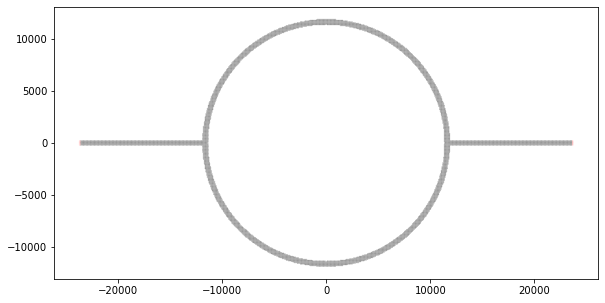

In [5]:
sys=make_system(nw, 2)
kwant.plot(sys, site_color=lambda site: sys.hamiltonian(site,site), fig_size=(10,5), colorbar=False, show=False, num_lead_cells=2);

# Relacje dyspersji w kontakcie

In [6]:
momenta, energies = disperssion(nw, 0, 0.1, 200)
plt.figure(figsize=(4,4))
plt.plot(momenta, np.asarray(energies)/eV2au(1.0),'k-')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.ylim((0,0.3))  
plt.xlim((-.5,.5))  
plt.xlabel("k [1/nm]",fontsize=22)
plt.ylabel("B [mT]",fontsize=22)
plt.subplots_adjust(bottom=0.2) 
plt.show()

TypeError: make_system() missing 1 required positional argument: 'Bz'

# Obliczenia konduktancji

0.0
0.00020408163265306123
0.00040816326530612246
0.0006122448979591836
0.0008163265306122449
0.0010204081632653062
0.0012244897959183673
0.0014285714285714286
0.0016326530612244899
0.0018367346938775511
0.0020408163265306124
0.0022448979591836735
0.0024489795918367346
0.002653061224489796
0.002857142857142857
0.0030612244897959186
0.0032653061224489797
0.0034693877551020408
0.0036734693877551023
0.0038775510204081634
0.004081632653061225
0.004285714285714286
0.004489795918367347
0.004693877551020408
0.004897959183673469
0.005102040816326531
0.005306122448979592
0.005510204081632653
0.005714285714285714
0.005918367346938775
0.006122448979591837
0.006326530612244898
0.006530612244897959
0.0067346938775510205
0.0069387755102040816
0.0071428571428571435
0.007346938775510205
0.007551020408163266
0.007755102040816327
0.007959183673469388
0.00816326530612245
0.00836734693877551
0.008571428571428572
0.008775510204081634
0.008979591836734694
0.009183673469387756
0.009387755102040816
0.00959183

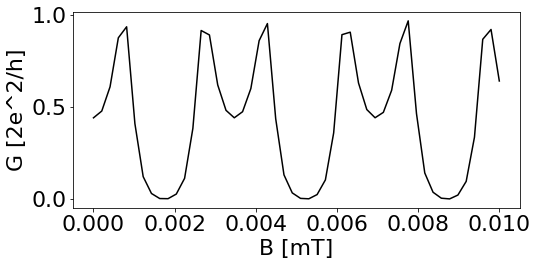

In [7]:
energies, cond=conductance(nw,0.01,50)
plt.figure(figsize=(8,4))
plt.plot(energies, cond,'k-')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel("B [mT]",fontsize=22)
plt.ylabel("G [2e^2/h]",fontsize=22)
plt.subplots_adjust(bottom=0.2) 
plt.savefig("B_cond.png")
plt.show()

# Funkcje falowe, DOS i gęstości prądu

/tmp/ipykernel_13898/319804900.py:44: RuntimeWarning: The plotted data contains 1.82% of values overflowing upper limit 97.9396 
  kwant.plotter.map(sys,density)


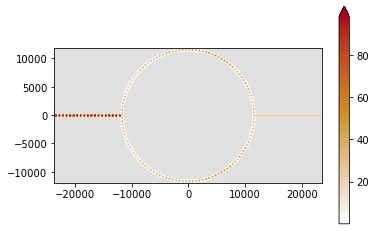

In [20]:
wave_function(nw, 0.05, 0, 0.0035)


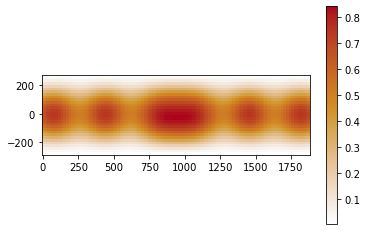

In [69]:
dos(nw, 0.1)

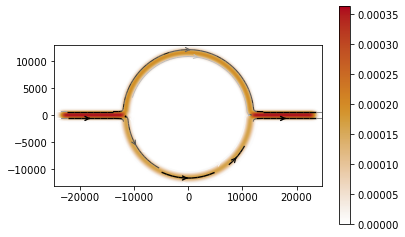

/tmp/ipykernel_13898/319804900.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.current(sys,curr)


In [21]:
current(nw, 0.05,0,0,0.0035)